# Clustering jerárquico y K-Means

Tomando como imput un dataset que contiene información de un centro comercial con datos básicos de los clientes, se aplicarán diferentes algoritmos de clustering para clasificarlos en grupos diferentes.

In [1]:
#librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#importamos el dataset
data = pd.read_csv("Mall_Customers.csv", sep=",")
data = pd.DataFrame(data)
data

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


Las variables son:
* CustomerID: identificador del cliente
* Género
* Edad
* Ingreso Anual (en miles)
* Spending Score: puntuación del 1 al 100  que le asigna al cliente en función de sus parámetros definidos, como el comportamiento del cliente y los datos de compra.

## 1. Análisis exploratorio de los datos.

In [3]:
# función para obtener un resumen de los datos
def getMetadata(dataframe) :
    metadata_matrix = pd.DataFrame({
                    'Tipo' : dataframe.dtypes, # tipo de datos
                    'Elementos': dataframe.count(), # cantidad de elementos en la columna
                    'Nulos': dataframe.isnull().sum(), # cantidad de nulos
                    'Nulos %': round(dataframe.isnull().sum()/len(dataframe) * 100,2) , #porcentaje de nulos
                    'Valores unicos': dataframe.nunique()
                       })
    return metadata_matrix

In [4]:
getMetadata(data)

,Tipo,Elementos,Nulos,Nulos %,Valores unicos
CustomerID,int64,200,0,0.0,200
Genre,object,200,0,0.0,2
Age,int64,200,0,0.0,51
Annual Income (k$),int64,200,0,0.0,64
Spending Score (1-100),int64,200,0,0.0,84


In [5]:
#tamaño
data.shape

(200, 5)

Vemos que el dataset tiene 200 filas y 5 columnas, con ningun valor nulo.

In [6]:
#resumen de las variables continuas
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


Algunas observaciones:
* La edad, como es de suponerse, sigue una distribución normal con media y mediana casi iguales. La edad promedio es de casi 39 años.
* Los ingresos anuales tienen un rango amplio, con un ingreso minimo de USD15K y máximo de USD137K, con promedio de USD60,5K
* El score, que va de 1 a 100, tiene distribución normal.

A continuacíon se profundiza la descrioción de cada una de estas variables

### Variable Edad

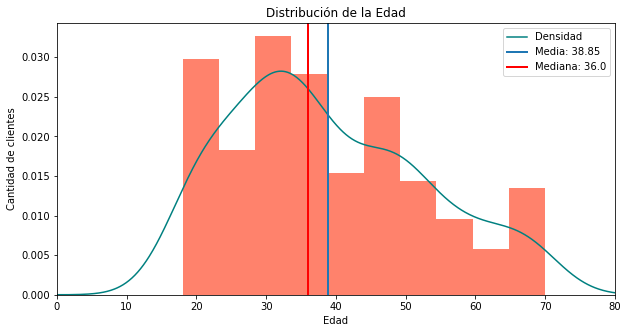

In [7]:
%matplotlib inline
plt.figure(figsize=(10,5))
plt.xlim([0,80])
plt.hist(x=data["Age"],density=True,color="tomato",alpha =0.8)
data["Age"].plot(kind='density', color='teal',label="Densidad")
plt.axvline(x=data["Age"].mean(),ymin=0,ymax=50,linewidth=2,label="Media: {}".format(data["Age"].mean()))
plt.axvline(x=data["Age"].median(),ymin=0,ymax=50,color="red",linewidth=2,label="Mediana: {}".format(data["Age"].median()))
plt.title("Distribución de la Edad")
plt.xlabel("Edad")
plt.ylabel("Cantidad de clientes")
plt.legend()
plt.show()

Tal como se comentío anteriormente, la edad tiende a ser una distribución normal. En el rango de entre aprox. 18 y 25 años se ven muchos clientes, lo cual es lógico pensando en un shopping.

### Variable Ingreso Anual

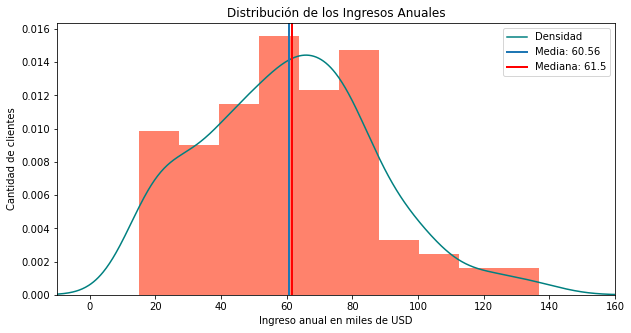

In [8]:
%matplotlib inline
plt.figure(figsize=(10,5))
plt.xlim([-10,160])
plt.hist(x=data["Annual Income (k$)"],density=True,color="tomato",alpha =0.8)
data["Annual Income (k$)"].plot(kind='density', color='teal',label="Densidad")
plt.axvline(x=data["Annual Income (k$)"].mean(),ymin=0,ymax=50,linewidth=2,label="Media: {}".format(data["Annual Income (k$)"].mean()))
plt.axvline(x=data["Annual Income (k$)"].median(),ymin=0,ymax=50,color="red",linewidth=2,label="Mediana: {}".format(data["Annual Income (k$)"].median()))
plt.title("Distribución de los Ingresos Anuales")
plt.xlabel("Ingreso anual en miles de USD")
plt.ylabel("Cantidad de clientes")
plt.legend()
plt.show()

La distribución de los ingresos también tiene su lógica: tiende a ser nomral, con la mayoría de las personas en los ingresos medios, y son pocos los que tienen ingresos muy por encima de la media. Aprox el 80% de los clientes tienen ingresos de entre USD15.000 Y USD90.000 anuales

### Variable Score

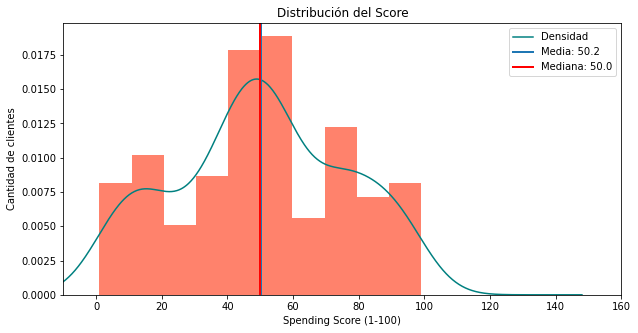

In [9]:
%matplotlib inline
plt.figure(figsize=(10,5))
plt.xlim([-10,160])
plt.hist(x=data["Spending Score (1-100)"],density=True,color="tomato",alpha =0.8)
data["Spending Score (1-100)"].plot(kind='density', color='teal',label="Densidad")
plt.axvline(x=data["Spending Score (1-100)"].mean(),ymin=0,ymax=50,linewidth=2,label="Media: {}".format(data["Spending Score (1-100)"].mean()))
plt.axvline(x=data["Spending Score (1-100)"].median(),ymin=0,ymax=50,color="red",linewidth=2,label="Mediana: {}".format(data["Spending Score (1-100)"].median()))
plt.title("Distribución del Score")
plt.xlabel("Spending Score (1-100)")
plt.ylabel("Cantidad de clientes")
plt.legend()
plt.show()

El score tiene una distribución nrmal con la media y la mediana casi iguales.

### Relación entre Ingresos y Score

Ingresos y Score son las dos variables que se van utilizar para hacer el clustering. Para ello, primero vemos en un gráfico la relación entre ambas. A priori, podemos imaginar que debería existir una relación positiva entre ingresos y score debería ser positiva, siendo los clientes con mayor poder adquisitvo los que tienen mejor puntuación.

Text(0, 0.5, 'Score')

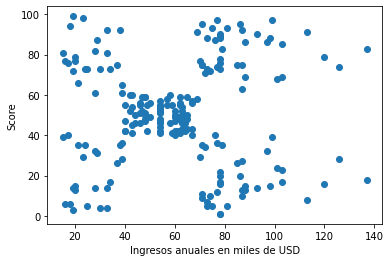

In [10]:
plt.scatter(x=data["Annual Income (k$)"], y=data["Spending Score (1-100)"])
plt.xlabel("Ingresos anuales en miles de USD")
plt.ylabel("Score")

Contrario a lo que se suponía, no existe una relación lineal entre ambas variables. Hay clientes con ingresos muy bajos y alto score, y viceversa. No se profundiza en esta relación ya que no es el objetivo de este análisis.

## 2. Clustering Jerárquico.

El clustering jerárquico tiene la ventaja que encuentra el numero de clusters por sí mismo y, por ende, no es necesario indicar este numero previo a generar el modelo.

In [11]:
#importamos las librerías
from scipy.cluster.hierarchy import dendrogram,linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import cdist

Como se mencionó anteriormente, para el clustering se utilizarán las variables de ingresos anuales y score asignado. En este caso, no es necesario normalizar las variables porque tienen una escala similar.

In [12]:
# generamos un dataframe con las dos variables
df = data[["Annual Income (k$)","Spending Score (1-100)" ]]

# cambiamos los nombres de las variables para simplificar
df = df.rename(columns={'Annual Income (k$)':'Ingresos Anuales',"Spending Score (1-100)":"Score"})

df.head()

,Ingresos Anuales,Score
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


In [13]:
# generamos la matriz de enlace Z con el metodo ward que minimiza la diferencia de los cuadrados
Z = linkage(df, "ward")

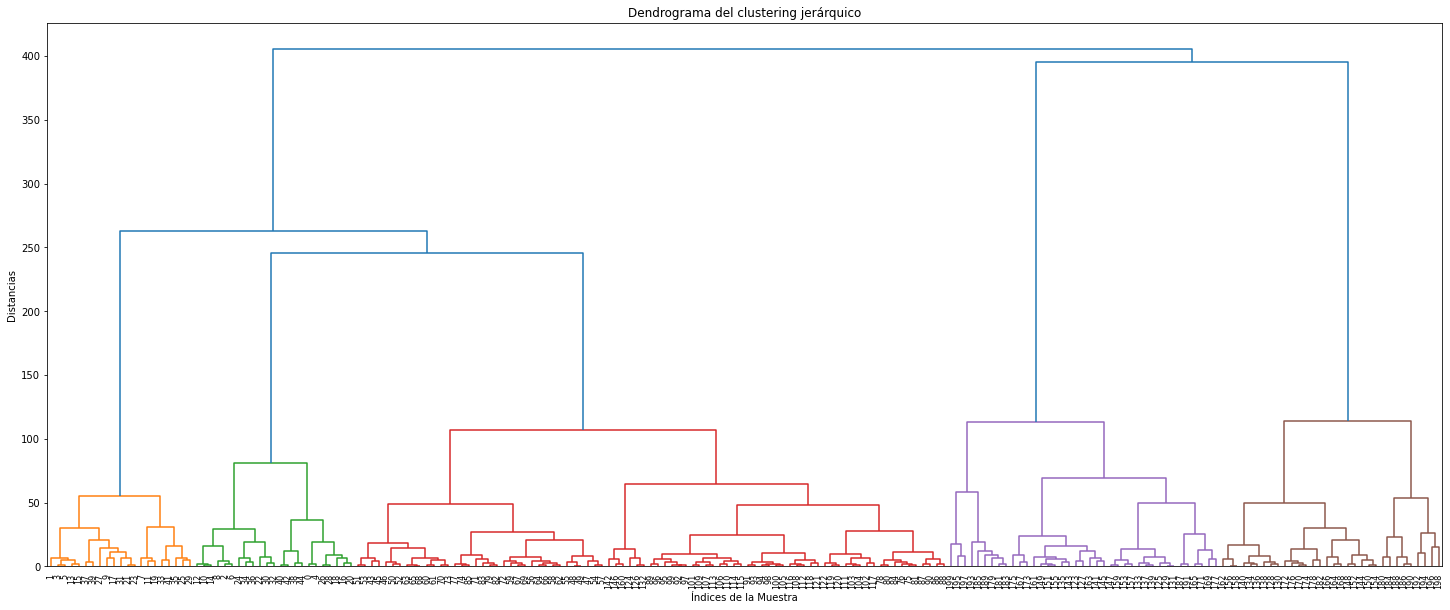

In [14]:
# pintamos el dendrograma
plt.figure(figsize=(25,10))
plt.title("Dendrograma del clustering jerárquico")
plt.xlabel("Índices de la Muestra")
plt.ylabel("Distancias")
dendrogram(Z, leaf_rotation=90., leaf_font_size=8.0, color_threshold=0.7*180)
plt.show()

A simple vista, vemos que el algoritmo encuentra 5 clusters a una distancia de corte aproximada de 120. Agregamos una línea para determinar este corte

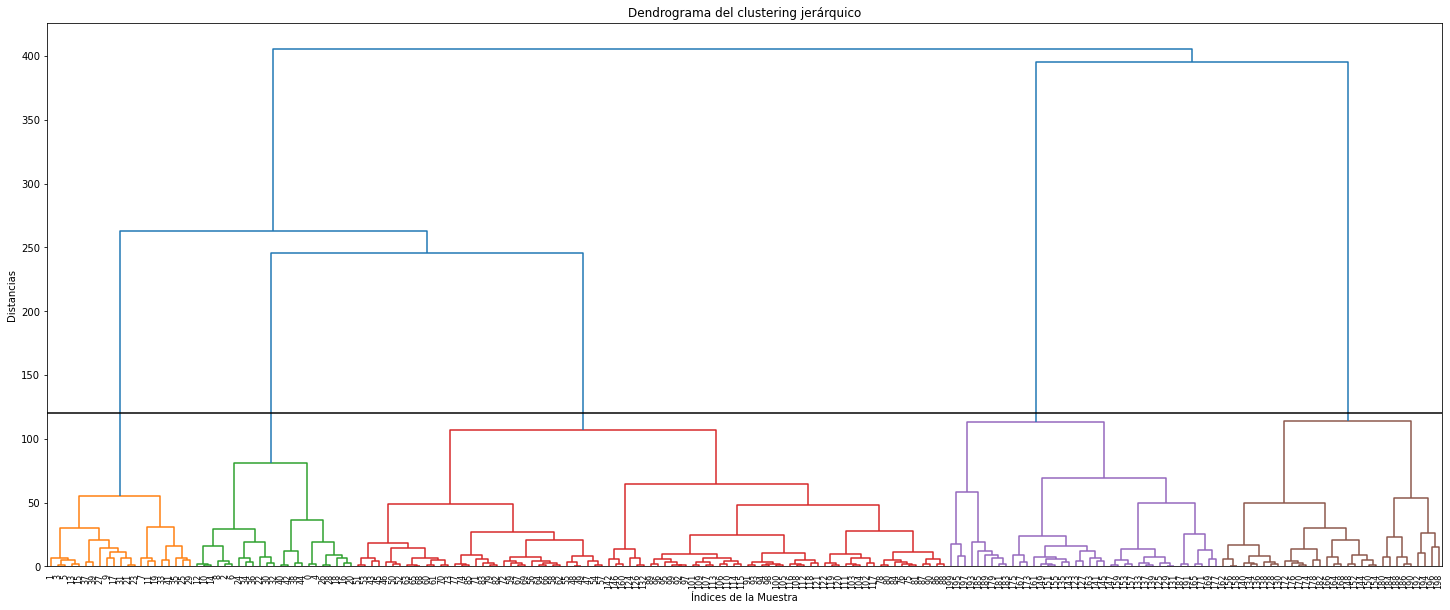

In [15]:
#determinamos la altura de corte
corte = 120

# pintamos el dendrograma

plt.figure(figsize=(25,10))
plt.title("Dendrograma del clustering jerárquico")
plt.xlabel("Índices de la Muestra")
plt.ylabel("Distancias")
plt.axhline(y=corte, color = "black")
dendrogram(Z, leaf_rotation=90., leaf_font_size=8.0, color_threshold=0.7*180)
plt.show()

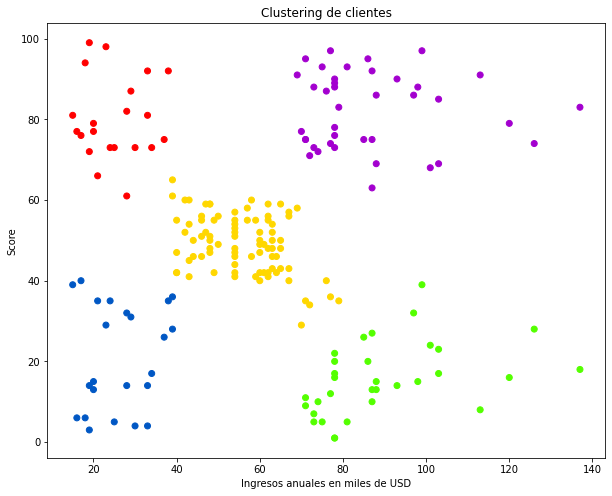

In [16]:
#pintamos los clusters en scatterplot

#generamos los clusters con la función fcluster y la altura de corte definida anteriormente.
#en este caos utilizamos el criteiro de las distancias para la agrupación
clusters = fcluster(Z, corte, criterion="distance")

#pintamos los clusters
plt.figure(figsize=(10,8)) #tamaño del gráfico
plt.scatter(df["Ingresos Anuales"], df["Score"], c = clusters, cmap="prism") #las dos columnas del array son las dos variables
plt.xlabel("Ingresos anuales en miles de USD")
plt.ylabel("Score")
plt.title("Clustering de clientes")
plt.show()

## 3. K-Means.

El algoritmo K-means necesita que se conozca primero el número de clusters.

In [17]:
#librerías de scikit-learn para K-means
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

In [18]:
#escalamos los datos para que esten en la misma escala
scaler = StandardScaler()
X = scaler.fit_transform(df)

El primer paso es determinar el numero de clusters. El algoritmo de clustering jerárquico lo hizo con 5 clusters, para hacerlo con K-means debemos primero utilizar el "método del codo" para determinar el numero ideal de clusters.

C:\Users\CarlosSecchi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0, 0.5, 'Intra-cluster (inertia)')

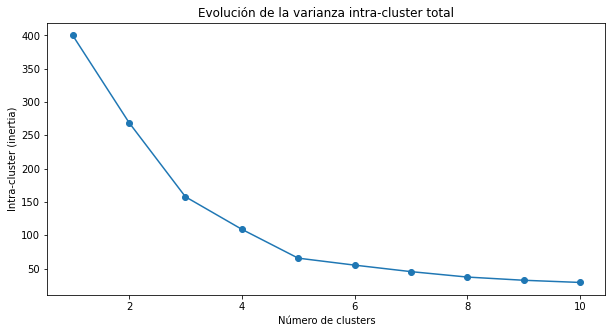

In [19]:
#definimos un rango de clusteres. Por ejemplo, de 1 a 10 inclusive
rango_k_clusters = range(1, 11)

# Lista vacía de las inertias. Inertia es la suma total de cuadrados internos de todos los clusters
inertias = []

# bucle para generar el modelo y definir la inertia para 1,2,3.. etc clusters.
for k in rango_k_clusters:
    modelo_kmeans = KMeans(n_clusters=k)
    modelo_kmeans.fit(X)
    inertias.append(modelo_kmeans.inertia_)

#pintamos la matriz del codo
plt.figure(figsize=(10,5))   
plt.plot(rango_k_clusters, inertias, marker='o')
plt.title("Evolución de la varianza intra-cluster total")
plt.xlabel('Número de clusters')
plt.ylabel('Intra-cluster (inertia)')

Vemos que el numero ideal de clusters es de 5, y concide con el clustering jerárquico.

In [20]:
#generamos el modelo K-means con 5 clusters
model = KMeans(n_clusters=5).fit(X)

# generamos un array con las etiquetas generadas por el modelo
labels = model.labels_

#generamos un array con los centroides 
centroides= model.cluster_centers_

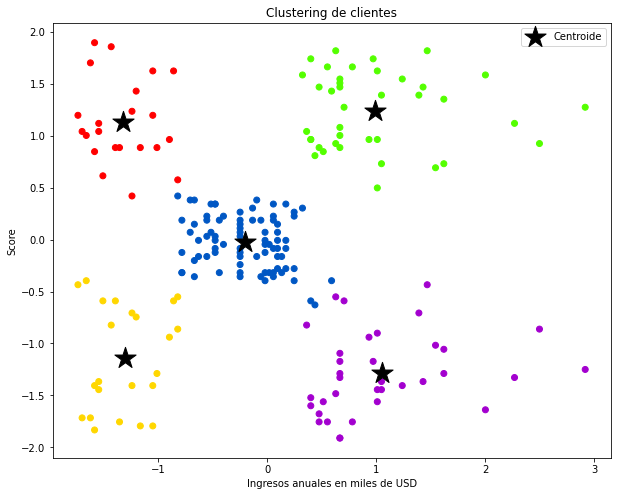

In [21]:
plt.figure(figsize=(10,8)) #tamaño del gráfico
plt.scatter(X[:,0], X[:,1], c = labels, cmap="prism") #las dos columnas del array son las dos variables
plt.scatter(centroides[:,0],centroides[:,1],marker="*",s=500,c="Black",label="Centroide")
plt.xlabel("Ingresos anuales en miles de USD")
plt.ylabel("Score")
plt.title("Clustering de clientes")
plt.legend()
plt.show()

In [22]:
plt

<module 'matplotlib.pyplot' from 'C:\\Users\\CarlosSecchi\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [23]:
# predecimos un nuevo cliente con ingresos anuales de 25mil USD y score de 100
new = model.predict([[100,1]])
new

array([3])